# DRAG

Two lowest energy levels are often singled out to represent a qubit in realizations of quantum computing. However, simple qubit control of these two levels fails at short time scales due to coupling and leakage to higher energy levels. [Derivative removal by adiabatic gate (DRAG)](https://www.nature.com/articles/s41534-020-00346-2) is a simple analytic pulse expression devised to combat this leakage. 

Let's consider the following Hamiltonian of a three level system that approximates a transmon qubit in a frame rotating at the qubit frequency

$$H(t) = \Delta|2\rangle\langle2| + \frac{\Omega_x(t)}{2}\sum_{j = 1}^{2}\sigma^x_{j, j-1} + \frac{\Omega_y(t)}{2}\sum_{j = 1}^{2}\sigma^y_{j, j-1},$$

where operators $\sigma^x_{j, j-1} = \sqrt{j}(|j\rangle\langle j-1| + |j-1\rangle\langle j|)$ and $\sigma^y_{j, j-1} = i\sqrt{j}(|j\rangle\langle j-1| - |j-1\rangle\langle j|)$ couple adjacent energy levels.

In [1]:
using QuantumOptimalControl
using QuantumOptics
using Flux
using Plots
using Random
using ProgressMeter

ProgressMeter.ijulia_behavior(:clear);

We define our Hamiltonian using [QuantumOptics.jl](https://qojulia.org/) library.

In [2]:
Δ = -0.3 * 2π

bs = NLevelBasis(3)
H0 = Δ * transition(bs, 3, 3)
Hx = transition(bs, 2, 1) + transition(bs, 1, 2) + √2 * (transition(bs, 3, 2) + transition(bs, 2, 3))
Hy = 1im * (transition(bs, 2, 1) - transition(bs, 1, 2) + √2 * (transition(bs, 3, 2) - transition(bs, 2, 3)));

To induce transitions $|0\rangle \leftrightarrow |1\rangle$, one can use the following Gaussian shaped parameterized DRAG pulses

$$\Omega_x(t) = A \left( \exp\left[ -\frac{\left(t-T/2\right)^2}{2\sigma^2} \right] - \exp\left[-\frac{T^2}{8\sigma^2}\right] \right),$$

$$\Omega_y(t) = \frac{\beta}{\Delta}\frac{\mathrm{d}\Omega_x(t)}{\mathrm{d}t}.$$

We set the spread of Gaussian to be a quarter of the total pulse duration $\sigma = T / 4$, while we keep the amplitudes $A$ and $\beta$ as free parameters to be optimized.

In [3]:
T = 4.0
σ = T / 4

Ωx(A, t) = A * (exp(-(t - T / 2)^2 / (2σ^2)) - exp(-T^2 / (8σ^2)))
Ωy(A, β, t) = -2 * (β / Δ) * A * (t - T / 2) * exp(-(t - T / 2)^2 / (2σ^2))

coeffs(p, t) = [Ωx(p[1], t) / 2, Ωy(p[1], p[2], t) / 2]

# initial parameters
θ = [0.0, 0.0];

Next, we define a cost function to be the infidelity between current and target states.

In [4]:
cost = CostFunction((x, y) -> 1.0 - abs2(x'*y));

We define define the desired unitary transformation as $R_x(\pi/2)$ rotation in the subspace spanned by the states $|0\rangle$ and $|1\rangle$.

In [5]:
trans = UnitaryTransform([nlevelstate(bs, 1), nlevelstate(bs, 2)], 
                         [[1.0 -1.0im];[-1.0im 1.0]]/√2);

Finally, we define and solve the corresponding quantum optimal control problem.

In [6]:
tspan = (0.0, T)
H = Hamiltonian(H0, [Hx, Hy], coeffs)
prob = QOCProblem(H, trans, tspan, cost)

@time sol = solve(prob, θ, ADAM(0.01); maxiter=200);

Progress: 100%|█████████████████████████████████████████| Time: 0:01:15
  distance:     0.004422796950737717
  constraints:  0.0


 94.248867 seconds (93.91 M allocations: 5.332 GiB, 63.32% gc time, 36.75% compilation time)


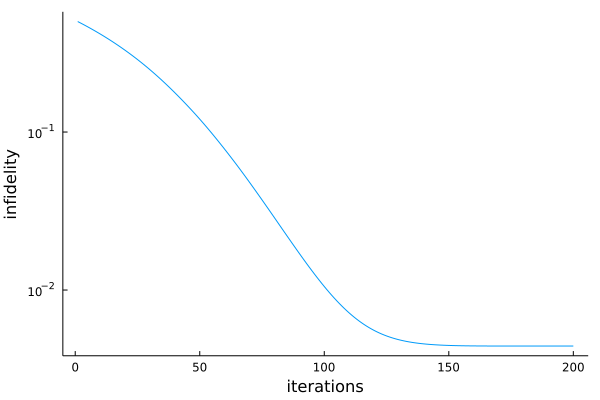

In [7]:
plot(sol.distance_trace, yscale=:log10, xlabel="iterations", ylabel="infidelity", grid=false, legend=false)

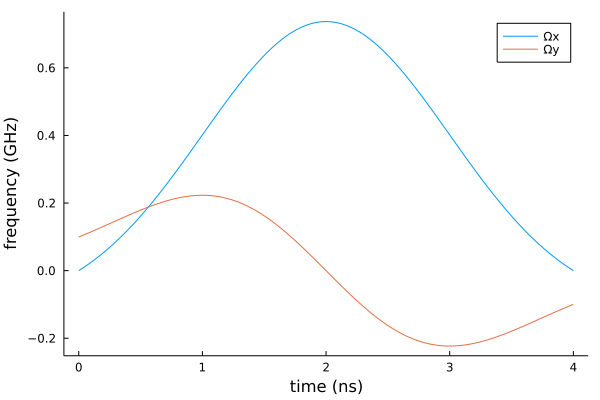

In [9]:
ts = collect(0:T/100.0:T)
plot(ts, Ωx.(sol.params[1], ts), label="Ωx")
plot!(ts, Ωy.(sol.params[1], sol.params[2], ts), label="Ωy")
plot!(xlabel="time (ns)", ylabel="frequency (GHz)", grid=false)